In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import re
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import traceback, warnings

### Load the excluded ingredients and two metadata files. Concatenate the metadata files into one. 

In [2]:
# Read the list of excluded ingredients
with open('excluded_ingredients.txt', 'r') as f:
    excluded_ingredients = set(line.strip() for line in f)

# Function to read metadata CSV files without headers and assign column names
def read_metadata(csv_file):
    # Read without headers
    metadata = pd.read_csv(csv_file, header=None, low_memory=False)
    num_cols = metadata.shape[1]
    
    # Define base columns and ingredient columns
    base_columns = ['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']
    ingredient_columns = ['ingr_{n}_id', 'ingr_{n}_name', 'ingr_{n}_grams', 'ingr_{n}_calories', 'ingr_{n}_fat', 'ingr_{n}_carb', 'ingr_{n}_protein']
    
    len_base = len(base_columns)
    len_ingr = len(ingredient_columns)
    max_n = (num_cols - len_base) // len_ingr
    
    # Generate column names
    columns = base_columns.copy()
    for n in range(1, max_n + 1):
        columns += [col.format(n=n) for col in ingredient_columns]
    
    # Check if total columns match
    if len(columns) != num_cols:
        print(f"Warning: Number of columns does not match for {csv_file}")
        # Optionally, handle or raise an error here
    
    metadata.columns = columns
    return metadata

# Read the metadata CSV files
metadata_cafe1 = read_metadata('nutrition5k_dataset/metadata/dish_metadata_cafe1.csv')
metadata_cafe2 = read_metadata('nutrition5k_dataset/metadata/dish_metadata_cafe2.csv')

# Concatenate the dataframes
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)
metadata.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein,ingr_1_id,ingr_1_name,ingr_1_grams,ingr_1_calories,...,ingr_33_fat,ingr_33_carb,ingr_33_protein,ingr_34_id,ingr_34_name,ingr_34_grams,ingr_34_calories,ingr_34_fat,ingr_34_carb,ingr_34_protein
0,dish_1561662216,300.794281,193,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1562688426,137.569992,88,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dish_1561662054,419.438782,292,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dish_1562008979,382.936646,290,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1560455030,20.590000,103,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create a sorted list of ingredients. Make sure that excluded ingredients are not in the list. (Some ingredients are excluded to overcome class imbalance and because the model is not likely to detect them, e.g. salt, pepper, wine, etc.)

In [3]:
# Extract ingredient indices from the column names
ingredient_indices = set()
for col in metadata.columns:
    m = re.match(r'ingr_(\d+)_name', col)
    if m:
        ingredient_indices.add(int(m.group(1)))
ingredient_indices = sorted(list(ingredient_indices))

# Construct a mapping from dish_id to ingredients (excluding excluded ingredients)
dish_ingredients = {}

for idx, row in metadata.iterrows():
    dish_id = row['dish_id']
    ingredients = []
    for n in ingredient_indices:
        ingr_name_col = f'ingr_{n}_name'
        if ingr_name_col in row and not pd.isna(row[ingr_name_col]):
            ingredient_name = str(row[ingr_name_col]).strip()
            if ingredient_name not in excluded_ingredients:
                ingredient = {
                    'name': ingredient_name,
                    'grams': row.get(f'ingr_{n}_grams', np.nan),
                    'calories': row.get(f'ingr_{n}_calories', np.nan),
                    'fat': row.get(f'ingr_{n}_fat', np.nan),
                    'carb': row.get(f'ingr_{n}_carb', np.nan),
                    'protein': row.get(f'ingr_{n}_protein', np.nan)
                }
                ingredients.append(ingredient)
    dish_ingredients[dish_id] = ingredients

# Create a list of all unique ingredients
all_ingredients_set = set()
for ingredients in dish_ingredients.values():
    for ingredient in ingredients:
        all_ingredients_set.add(ingredient['name'])

all_ingredients = sorted(list(all_ingredients_set))
ingredient_to_index = {ingredient: idx for idx, ingredient in enumerate(all_ingredients)}

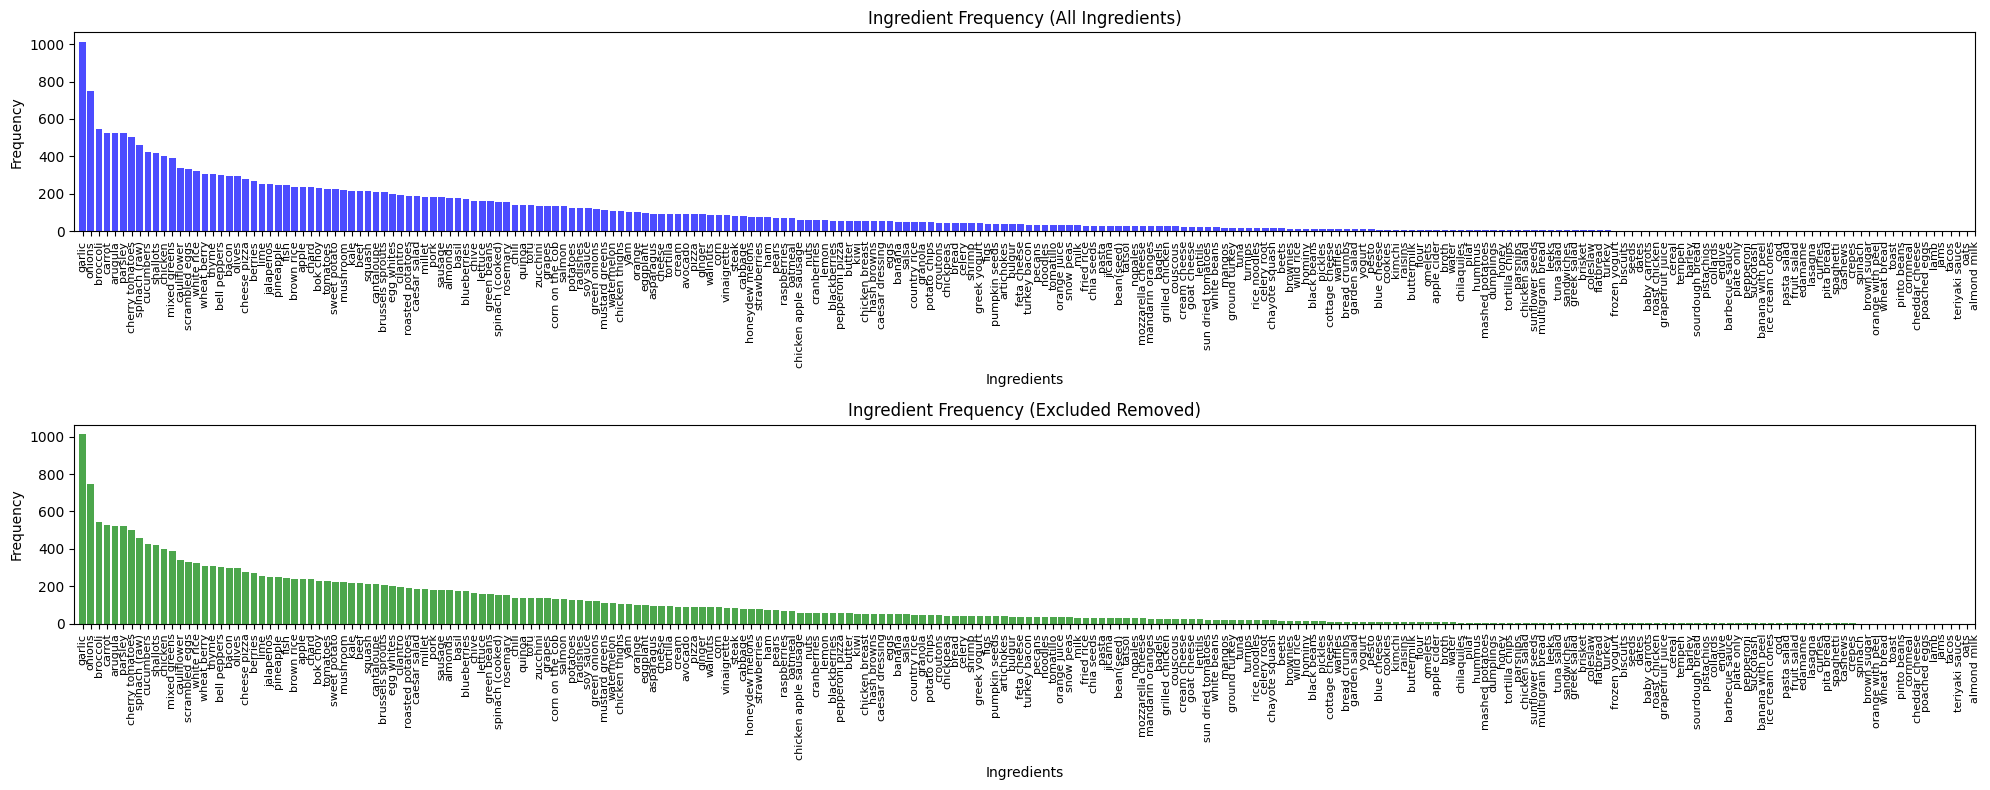

In [4]:
# Create ingredient frequency dictionaries
ingredient_counts_all = {}
ingredient_counts_filtered = {}

for ingredients in dish_ingredients.values():
    for ingredient in ingredients:
        # Count all ingredients
        ingredient_name = ingredient['name']
        ingredient_counts_all[ingredient_name] = ingredient_counts_all.get(ingredient_name, 0) + 1
        
        # Count after filtering excluded ingredients
        if ingredient_name not in excluded_ingredients:
            ingredient_counts_filtered[ingredient_name] = ingredient_counts_filtered.get(ingredient_name, 0) + 1

# Sort ingredients by frequency (descending order)
sorted_ingredients_all = sorted(ingredient_counts_all.items(), key=lambda x: x[1], reverse=True)
sorted_ingredients_filtered = sorted(ingredient_counts_filtered.items(), key=lambda x: x[1], reverse=True)

# Extract data for plotting
ingredients_all, counts_all = zip(*sorted_ingredients_all)
ingredients_filtered, counts_filtered = zip(*sorted_ingredients_filtered)

# Plot histograms
plt.figure(figsize=(20, 8))

# Histogram for all ingredients
plt.subplot(2, 1, 1)
bars_all = plt.bar(ingredients_all, counts_all, color='blue', alpha=0.7)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('Ingredient Frequency (All Ingredients)')
plt.xlim(-1, len(ingredients_all) - 1)  # Reduce whitespace on x-axis

# Histogram for filtered ingredients
plt.subplot(2, 1, 2)
bars_filtered = plt.bar(ingredients_filtered, counts_filtered, color='green', alpha=0.7)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Ingredients')
plt.ylabel('Frequency')
plt.title('Ingredient Frequency (Excluded Removed)')
plt.xlim(-1, len(ingredients_filtered) - 1)  # Reduce whitespace on x-axis

plt.tight_layout()  # Adjust layout to minimize empty space
plt.show()

### Only use metadata rows for which there is an image in the imagery/realsense_overhead folder.

In [5]:
# Prepare the dataset with image paths and labels
data = []

count=0
for dish_id, ingredients in dish_ingredients.items():
    image_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
    if os.path.exists(image_path):
        # Create the multi-hot label vector
        label = np.zeros(len(all_ingredients), dtype=np.float32)
        for ingredient in ingredients:
            idx = ingredient_to_index[ingredient['name']]
            label[idx] = 1.0
        data.append({
            'dish_id': dish_id,
            'image_path': image_path,
            'label': label
        })
    else:
        count += 1
        print(f"There are {count} dish_id that have no image at nutrition5k_dataset/imagery/realsense_overhead.", end="\r")

There are 1516 dish_id that have no image at nutrition5k_dataset/imagery/realsense_overhead.

### Display two examples of binarized ingredients data in the labels.

In [6]:
data[:2]

[{'dish_id': 'dish_1561662216',
  'image_path': 'nutrition5k_dataset/imagery/realsense_overhead/dish_1561662216/rgb.png',
  'label': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0

### Define training and validation datasets.

In [7]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare lists of image paths and labels
train_image_paths = [item['image_path'] for item in train_data]
train_labels = [item['label'] for item in train_data]

val_image_paths = [item['image_path'] for item in val_data]
val_labels = [item['label'] for item in val_data]

### Preprocess the images for MobileNetV3.  Create the training and validation datasets.

In [8]:
# Load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

# Create TensorFlow datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Create a custom F1-score for this model
A custom F1 score was used because the tf.keras function cannot be used as part of the metric panel. The F1 score is calculated at the very end of training, and to get the F1 score over the entire validation set, one could use micro-averaging (average="micro"). However, one additional advantage of having a custom F1 score function is that we can restrict the score over relevant classes, i.e. not counting classes for which there is no entry in either the true or predicted class.  This is a potential issue as we have excluded ingredients which would likely be invisible on the photographic images. Using this custom function allows us to report the F1 score at the end of each epoch over the entire validation dataset, by loading it into memory before training and comparing the predictions with all the true labels.

In [9]:
threshold = 0.5  # Set threshold for calculating F1-score.

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Metric

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()

# Validation dataset pointer has to be reset to the beginning. Load images into NumPy arrays once again. 
val_x = np.array([load_and_preprocess_image(path) for path in val_image_paths])
val_y = np.array(val_labels)     # Ensure val_labels is a NumPy array, too.


class F1Score(Metric):
    def __init__(self, num_classes, name='f1_score', threshold=threshold, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.num_classes = num_classes  # Total number of classes
        
        # Initialize accumulators for true positives, false positives, false negatives
        self.tp = self.add_weight(name='tp', shape=(self.num_classes,), initializer='zeros')
        self.fp = self.add_weight(name='fp', shape=(self.num_classes,), initializer='zeros')
        self.fn = self.add_weight(name='fn', shape=(self.num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Binarize predictions using the threshold
        y_pred = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        # Compute per-class true positives, false positives, false negatives
        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
        
        # Update accumulators
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)
            
    def result(self):
        # Compute precision and recall per class
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
        
        # Compute F1 score per class
        f1_per_class = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        
        # Identify relevant classes (classes with at least one true positive or predicted positive)
        relevant = (self.tp + self.fp + self.fn) > 0
        
        # Filter relevant classes
        f1_per_class = tf.boolean_mask(f1_per_class, relevant)
        supports = tf.boolean_mask(self.tp + self.fn, relevant)  # Number of true instances per class
        
        # Compute weighted average F1 score
        weighted_f1 = tf.math.divide_no_nan(tf.reduce_sum(f1_per_class * supports), tf.reduce_sum(supports))
        
        # Handle case when there are no relevant classes
        weighted_f1 = tf.where(tf.math.is_nan(weighted_f1), tf.zeros_like(weighted_f1), weighted_f1)
        
        return weighted_f1
    
    def reset_states(self):
        # Reset accumulators
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))

# Determine the number of classes
class_names = all_ingredients
num_classes = len(class_names)

# Create an instance of the custom metric
f1_metric = F1Score(num_classes=num_classes, name='f1_score')

### Define the model, based on MobileNetV3Large. Set freezing layer for transfer learning. Define custom layers. Compile the model. Visualize total layers. 

In [10]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from sklearn.metrics import f1_score
from keras import regularizers

# Load the pre-trained MobileNetV3 model without the top layers
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Specify freezing layer
for layer in base_model.layers[:90]:
    layer.trainable = False
for layer in base_model.layers[90:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(x)
x = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-3))(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(len(all_ingredients), activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        BinaryAccuracy(name='binary_accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', multi_label=True),
        f1_metric
    ]
)

print(f"Model has {len(model.layers)} layers, of which {len(base_model.layers)} come from MobileNetV3")

Model has 193 layers, of which 187 come from MobileNetV3


### Set epoch number and start training the model.

In [11]:
epochs = 80

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)

Epoch 1/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 318ms/step - auc: 0.4367 - binary_accuracy: 0.7665 - f1_score: 0.1081 - loss: 2.0079 - precision: 0.0303 - recall: 0.2743 - val_auc: 0.4900 - val_binary_accuracy: 0.9779 - val_f1_score: 0.0000e+00 - val_loss: 1.2984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 320ms/step - auc: 0.5661 - binary_accuracy: 0.9763 - f1_score: 0.0259 - loss: 1.1912 - precision: 0.7568 - recall: 0.0183 - val_auc: 0.5240 - val_binary_accuracy: 0.9784 - val_f1_score: 0.0345 - val_loss: 0.9035 - val_precision: 0.8070 - val_recall: 0.0256
Epoch 3/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 321ms/step - auc: 0.6120 - binary_accuracy: 0.9764 - f1_score: 0.0644 - loss: 0.8262 - precision: 0.7187 - recall: 0.0548 - val_auc: 0.5458 - val_binary_accuracy: 0.9784 - val_f1_score: 0.0374 - val_loss: 0.6267 - val_precision: 0.7970 - val_recall: 0.0295
Epoch 4/80
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - auc: 0.6270 - binary_accuracy: 0.976

### Plot loss, accuracy, AUC and F1 score

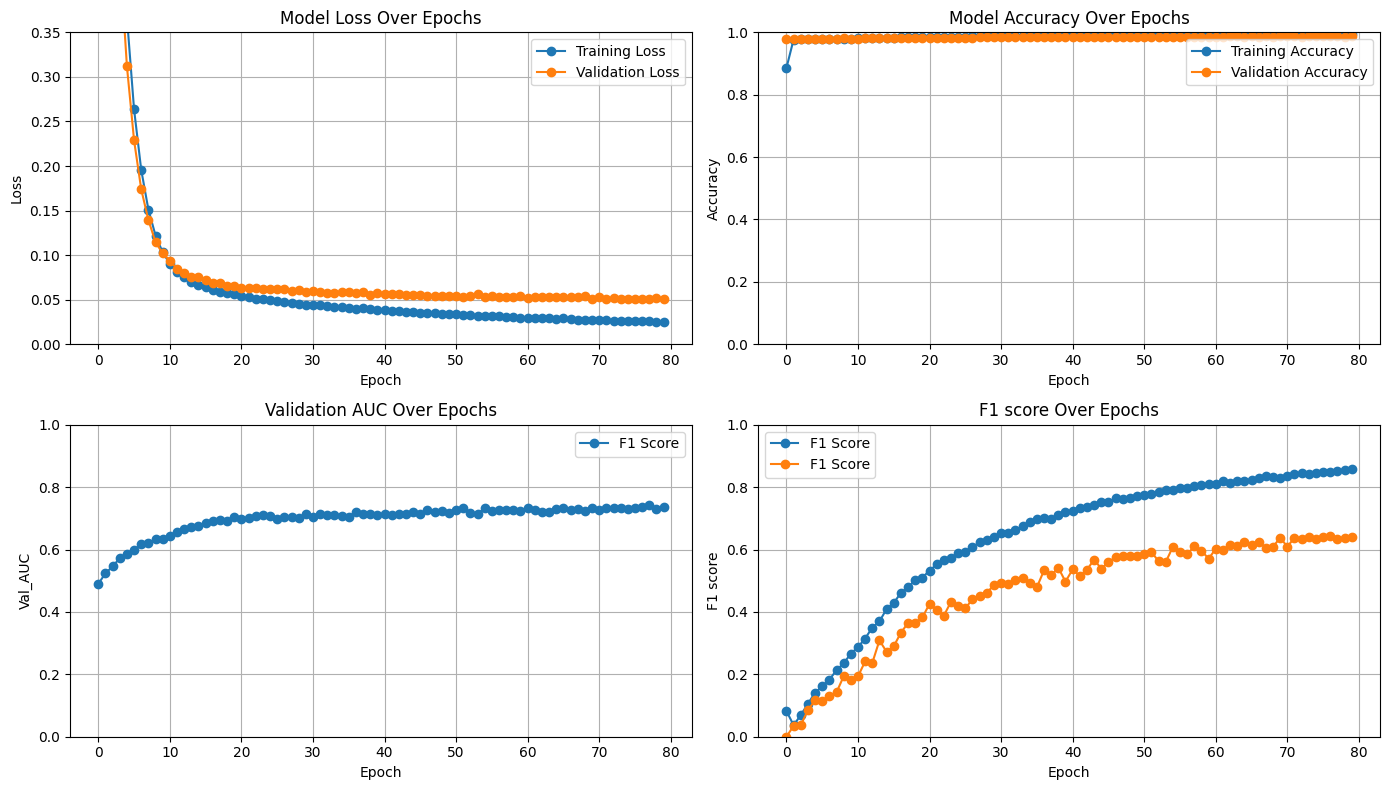

In [12]:
# Plot training & validation loss values
plt.figure(figsize=(14, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.ylim(0,0.35)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.ylim(0,1)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC Plot
plt.subplot(2, 2, 3)
plt.ylim(0,1)
plt.plot(history.history['val_auc'], label='F1 Score', marker='o')
plt.title('Validation AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Val_AUC')
plt.legend()
plt.grid(True)

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.ylim(0,1)
plt.plot(history.history['f1_score'], label='F1 Score', marker='o')
plt.plot(history.history['val_f1_score'], label='F1 Score', marker='o')
plt.title('F1 score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Calculate Hamming Score

In [13]:
from sklearn.metrics import hamming_loss

# Reset the validation dataset pointer to the beginning. 
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image.numpy()  # Convert to NumPy array

# Load validation images into NumPy arrays
val_x = np.array([load_and_preprocess_image(path) for path in val_image_paths])

# Convert labels to NumPy arrays
val_y = np.array(val_labels)

# Now we can collect predictions on the validation data
y_pred_probs = model.predict(val_x)
y_pred = (y_pred_probs >= 0.5).astype(int)
y_true = val_y

# Compute Hamming Score
hamming = hamming_loss(y_true, y_pred)
hamming_score = 1 - hamming
print(f"Validation Hamming Score: {hamming_score:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step 
Validation Hamming Score: 0.9871


### Make predictions. Adjust prediction threshold value as needed. 

In [14]:
threshold = 0.5   # Adjust threshold for visualizations.

def predict_ingredients(model, image_path, ingredient_to_index, threshold=threshold):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension

    # Make predictions on the selected image
    predictions = model.predict(image)[0]

    # Get predicted ingredients based on the threshold
    predicted_indices = [i for i, p in enumerate(predictions) if p >= threshold]

    # Map indices to ingredient names
    predicted_ingredients = [index_to_ingredient[idx] for idx in predicted_indices]

    return predicted_ingredients

# Function to calculate total nutritional information
def calculate_nutrition(predicted_ingredients, ingredient_data):
    total_nutrition = {
        'grams': 0.0,
        'calories': 0.0,
        'fat': 0.0,
        'carb': 0.0,
        'protein': 0.0
    }
    for ingr_name in predicted_ingredients:
        # Find the ingredient data from the metadata
        for dish_id, ingredients in dish_ingredients.items():
            for ingredient in ingredients:
                if ingredient['name'] == ingr_name:
                    total_nutrition['grams'] += ingredient['grams']
                    total_nutrition['calories'] += ingredient['calories']
                    total_nutrition['fat'] += ingredient['fat']
                    total_nutrition['carb'] += ingredient['carb']
                    total_nutrition['protein'] += ingredient['protein']
                    break  # Assuming ingredient names are unique
    return total_nutrition


test_image_path = val_image_paths[1]

# Map 'ingredient_to_index' and 'index_to_ingredient'
ingredient_to_index = {ingredient: index for index, ingredient in enumerate(class_names)}
index_to_ingredient = {index: ingredient for index, ingredient in enumerate(class_names)}

predicted_ingredients = predict_ingredients(model, test_image_path, ingredient_to_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


### Predict on the test set.  Use the dropdown selector to select a dish. 

In [15]:
# Read glycemic index data
glycemic_index_df = pd.read_excel('glycemic_index.xlsx')

# Create a dictionary mapping from ingredient to glycemic index
gi_dict = dict(zip(glycemic_index_df['Item'], glycemic_index_df['Glycemic index']))

In [16]:
def get_ingredients_for_dish(dish_id):
    # Filter the row corresponding to the selected dish
    dish_row = metadata[metadata['dish_id'] == dish_id]
    if dish_row.empty:
        print(f"No data found for dish_id: {dish_id}")
        return []
    
    dish_row = dish_row.iloc[0]
    
    # Find all ingredient columns
    ingredient_columns = [col for col in metadata.columns if 'ingr_' in col]
    # Get unique n values
    n_values = set()
    for col in ingredient_columns:
        parts = col.split('_')
        if len(parts) >= 3:
            n = parts[1]
            n_values.add(n)
    
    ingredients = []
    for n in n_values:
        ingr_name_col = f'ingr_{n}_name'
        ingr_grams_col = f'ingr_{n}_grams'
        ingr_carb_col = f'ingr_{n}_carb'
        
        # Check if the ingredient name exists
        ingredient_name = dish_row.get(ingr_name_col)
        if pd.notnull(ingredient_name):
            # Get the mass and carbohydrate content per 100g
            mass = dish_row.get(ingr_grams_col, 0)
            carb_per_100g = dish_row.get(ingr_carb_col, 0)
            # Add the ingredient data to the list
            ingredients.append({
                'name': ingredient_name,
                'mass': mass,
                'carb_per_100g': carb_per_100g
            })
    return ingredients

In [17]:
# Calculates the glycemic index and load from a list of ingredients.
def calculate_glycemic_index_and_load(ingredients):
    total_mass = 0
    weighted_gi_sum = 0
    total_carb = 0
    missing_ingredients = []
    
    for ingredient in ingredients:
        if isinstance(ingredient['name'], dict):
            # Extract the actual name from the dictionary
            name = ingredient['name'].get('name', 'Unknown')
        else:
            name = ingredient['name']
        
        # print(f"name: {name}")
        
        mass = ingredient.get('mass', ingredient.get('grams', 0)) 
        carb_per_100g = ingredient.get('carb_per_100g', ingredient.get('carb', 0))
        gi = gi_dict.get(name)
        
        if gi is None:
            missing_ingredients.append(name)
            continue
            
        # Ensure mass and carb_per_100g are float numbers
        mass = float(mass) if pd.notnull(mass) else 0
        carb_per_100g = float(carb_per_100g) if pd.notnull(carb_per_100g) else 0
        
        carb_content = mass * (carb_per_100g / 100)
        
        total_mass += mass
        total_carb += carb_content
        weighted_gi_sum += gi * mass
        
    if total_mass > 0:
        gi_dish = weighted_gi_sum / total_mass
    else:
        gi_dish = 0  # Handle case where total_mass == 0
    
    # Glycemic Load calculation
    gl_dish = (total_carb * gi_dish) / 100
    
    if missing_ingredients:
        print(f"Warning: Missing GI data for ingredients: {', '.join(missing_ingredients)}. GI set to 0 for these ingredients.")
    
    return gi_dish, gl_dish

### Select a dish from the validation set using a drop down menu and display image, nutritional information, and glycemic index.

In [18]:
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

nutritional_data = pd.read_csv('nutrition5k_dataset/metadata/ingredients_metadata.csv') 
# Rename columns to standard names
nutritional_data.rename(columns={
    'ingr': 'ingredient',
    'cal/g': 'calories',
    'fat(g)': 'fat',
    'carb(g)': 'carbohydrates',
    'protein(g)': 'protein'
}, inplace=True)

# Create a dictionary for quick lookup. The key is the ingredient name; the value is a dictionary of nutritional info per 100g
warnings.filterwarnings("ignore", category=UserWarning)
ingredient_nutrition_db = nutritional_data.set_index('ingredient').T.to_dict()
warnings.resetwarnings()
# Create a mapping of dish_id to image_path in the validation set
val_dish_ids = [item['dish_id'] for item in val_data]
val_image_paths = [item['image_path'] for item in val_data]
dish_id_to_image_path = {item['dish_id']: item['image_path'] for item in val_data}
# Create 'ingredient_to_index' and 'index_to_ingredient' mappings
ingredient_to_index = {ingredient: index for index, ingredient in enumerate(class_names)}
index_to_ingredient = {index: ingredient for index, ingredient in enumerate(class_names)}

# Define the function to predict ingredients
def predict_ingredients(model, image_path, ingredient_to_index, threshold=threshold):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension

    # Make predictions on the selected image
    predictions = model.predict(image)[0]

    # Get predicted ingredients based on the threshold
    predicted_indices = [i for i, p in enumerate(predictions) if p >= threshold]
    # Map indices to ingredient names
    predicted_ingredients = [index_to_ingredient[idx] for idx in predicted_indices]

    return predicted_ingredients

# Define function to calculate total nutritional information based on predicted ingredients
def get_total_nutritional_info(predicted_ingredients):
    # Initialize total nutritional values
    total_mass = 0
    total_calories = 0.0
    total_fat = 0.0
    total_carb = 0.0
    total_protein = 0.0

    default_mass = 100  # grams per ingredient if actual mass is unknown

    # Prepare a list of ingredient dicts for GI calculation
    ingredients_for_gi = []

    for ingredient_name in predicted_ingredients:
        ingredient_key = ingredient_name.lower().strip()
        nutrition = ingredient_nutrition_db.get(ingredient_key)
        if nutrition:
            try:
                # Use actual mass if available or default mass
                mass = default_mass
                calories = float(nutrition['calories'])
                fat = float(nutrition['fat'])
                carb = float(nutrition['carbohydrates'])
                protein = float(nutrition['protein'])
                total_mass += mass
                total_calories += calories * (mass / 100)
                total_fat += fat * (mass / 100)
                total_carb += carb * (mass / 100)
                total_protein += protein * (mass / 100)

                # Prepare ingredient dict for GI calculation
                ingredient_dict = {
                    'name': ingredient_name,
                    'mass': mass,
                    'carb_per_100g': carb
                }
                ingredients_for_gi.append(ingredient_dict)
            except KeyError as e:
                print(f"KeyError: {e} not found for ingredient: {ingredient_name}")
        else:
            print(f"Nutritional information not found for ingredient: {ingredient_name}")

    # Now calculate GI and GL using your function
    gi_dish, gl_dish = calculate_glycemic_index_and_load(ingredients_for_gi)

    total_info = {
        'total_mass': total_mass,
        'total_calories': total_calories,
        'total_fat': total_fat,
        'total_carb': total_carb,
        'total_protein': total_protein,
        'gi_dish': gi_dish,
        'gl_dish': gl_dish
    }

    return total_info

# Create the dropdown widget with dish_ids
dropdown = widgets.Dropdown(
    options=list(dish_id_to_image_path.keys()),
    description='Dish ID:',
    disabled=False,
)

# Create an Output widget to capture and display outputs
output = widgets.Output()

# Define the event handler for the dropdown widget
def on_dropdown_change(change):
    dish_id = change['new']  # Extract the dish_id
    with output:
        output.clear_output()

        print(f"Dish ID: {dish_id}")

        # Display the dish image
        image_path = dish_id_to_image_path.get(dish_id)
        if image_path:
            display(Image(filename=image_path))
        else:
            print("No image available for this dish.")
            return

        # Predict ingredients from the image
        try:
            predicted_ingredients = predict_ingredients(model, image_path, ingredient_to_index)
            print(f"\nPredicted Ingredients:\n{predicted_ingredients}\n")
        except KeyError as e:
            print(f"Error: {e}. This index is not in 'index_to_ingredient'.")
            print("Ensure 'class_names' aligns with the model's output classes.")
            return

        # Get total nutritional information based on predicted ingredients
        total_info = get_total_nutritional_info(predicted_ingredients)
        if total_info is None:
            print("No nutritional information found for the predicted ingredients.")
            return

        # Display the results
        print(f"Total Mass (grams): {total_info['total_mass']}")
        print(f"Total Calories: {total_info['total_calories']:.2f} kcal")
        print(f"Total Fat: {total_info['total_fat']:.2f} grams")
        print(f"Total Carbohydrates: {total_info['total_carb']:.2f} grams")
        print(f"Total Protein: {total_info['total_protein']:.2f} grams")
        print()
        print(f"Glycemic Index of the Dish: {total_info['gi_dish']:.2f}")
        print(f"Glycemic Load of the Dish: {total_info['gl_dish']:.2f}")
        print("\n")

# Attach the event handler to the dropdown widget
dropdown.observe(on_dropdown_change, names='value')

# Display the dropdown widget and output together using VBox
ui = widgets.VBox([dropdown, output])
display(ui)

# Manually trigger the handler to display initial information
if dropdown.value is not None:
    on_dropdown_change({'new': dropdown.value})

### Randomly select five dish IDs from the validation set, and display the dish image, nutritional information and glycemic load. 

Number of classes in model output: 233
Number of class names: 233
Number of classes matches the number of ingredients.

Processing dish ID: dish_1565640528
Image path for dish ID dish_1565640528: nutrition5k_dataset/imagery/realsense_overhead/dish_1565640528/rgb.png


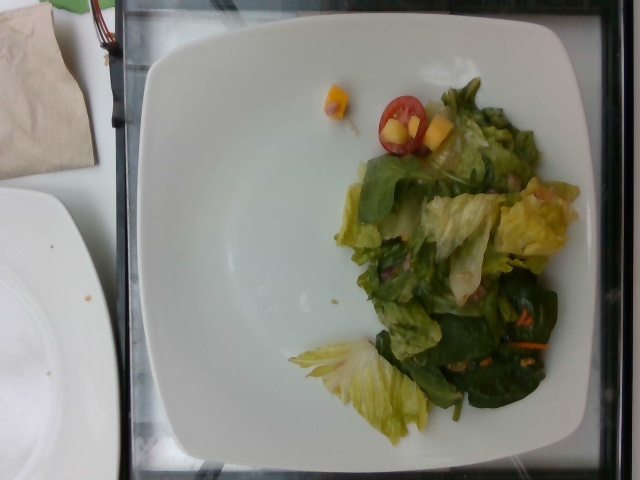

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Predicted ingredients:
['arugula', 'cherry tomatoes', 'cilantro', 'cucumbers', 'garlic', 'jalapenos', 'mangos', 'mustard greens', 'onions', 'tomatoes']

Total Mass (grams): 1000
Total Calories: 4.15 kcal
Total Fat: 0.04 grams
Total Carbohydrates: 0.88 grams
Total Protein: 0.20 grams
Glycemic Index of the dish: 33.00
Glycemic Load of the dish: 0.29
--------------------------------------------------

Processing dish ID: dish_1559848929
Image path for dish ID dish_1559848929: nutrition5k_dataset/imagery/realsense_overhead/dish_1559848929/rgb.png


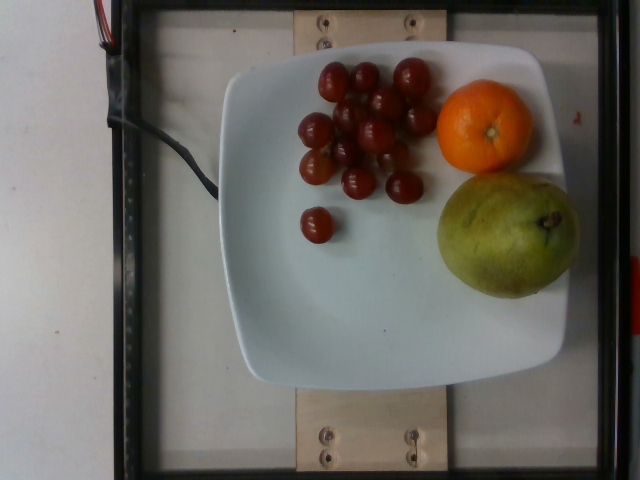

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Predicted ingredients:
['grapes', 'mandarin oranges', 'pears']

Total Mass (grams): 300
Total Calories: 1.79 kcal
Total Fat: 0.01 grams
Total Carbohydrates: 0.46 grams
Total Protein: 0.02 grams
Glycemic Index of the dish: 43.67
Glycemic Load of the dish: 0.20
--------------------------------------------------

Processing dish ID: dish_1565811423
Image path for dish ID dish_1565811423: nutrition5k_dataset/imagery/realsense_overhead/dish_1565811423/rgb.png


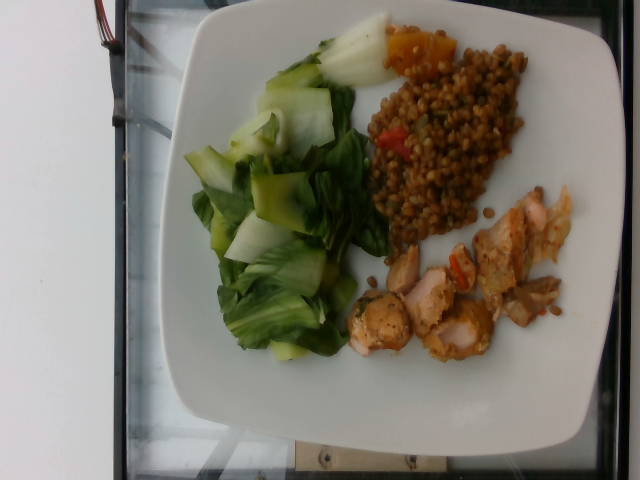

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Predicted ingredients:
['arugula', 'brown rice', 'salmon', 'thyme']

Total Mass (grams): 400
Total Calories: 4.15 kcal
Total Fat: 0.11 grams
Total Carbohydrates: 0.51 grams
Total Protein: 0.35 grams
Glycemic Index of the dish: 24.25
Glycemic Load of the dish: 0.12
--------------------------------------------------

Processing dish ID: dish_1562010369
Image path for dish ID dish_1562010369: nutrition5k_dataset/imagery/realsense_overhead/dish_1562010369/rgb.png


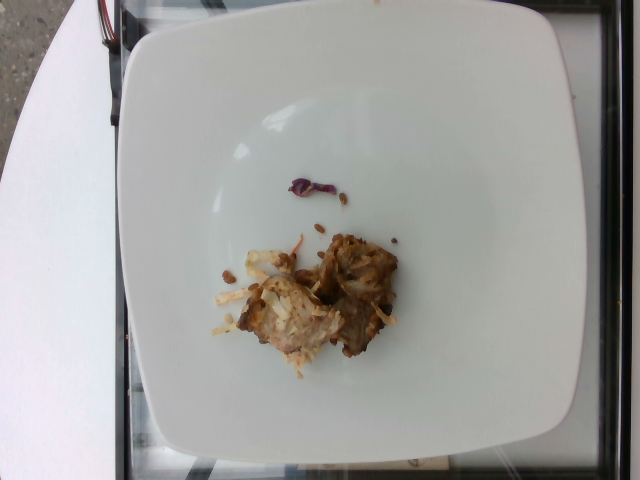

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Predicted ingredients:
['arugula', 'carrot', 'garlic', 'parsley', 'pork']

Total Mass (grams): 500
Total Calories: 4.90 kcal
Total Fat: 0.16 grams
Total Carbohydrates: 0.53 grams
Total Protein: 0.39 grams
Glycemic Index of the dish: 27.00
Glycemic Load of the dish: 0.14
--------------------------------------------------

Processing dish ID: dish_1558640039
Image path for dish ID dish_1558640039: nutrition5k_dataset/imagery/realsense_overhead/dish_1558640039/rgb.png


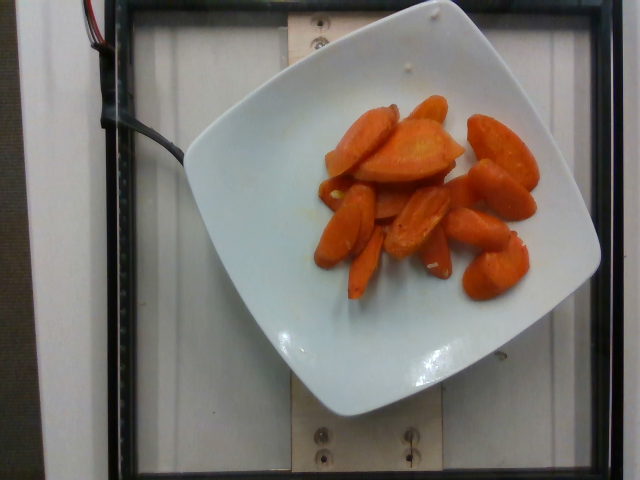

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted ingredients:
['carrot']

Total Mass (grams): 100
Total Calories: 0.41 kcal
Total Fat: 0.00 grams
Total Carbohydrates: 0.10 grams
Total Protein: 0.01 grams
Glycemic Index of the dish: 41.00
Glycemic Load of the dish: 0.04
--------------------------------------------------


In [19]:
import random
from IPython.display import display, Image, HTML
from PIL import Image as PILImage
import numpy as np
import os
import warnings
import pandas as pd

# Map 'dish_id' to 'image_path' in the validation set
dish_id_to_image_path = {item['dish_id']: item['image_path'] for item in val_data}
val_dish_ids = [item['dish_id'] for item in val_data]

class_names = all_ingredients
num_classes = len(class_names)

print(f"Number of classes in model output: {model.output_shape[1]}")
print(f"Number of class names: {num_classes}")

if model.output_shape[1] != num_classes:
    print(f"Error: Model outputs {model.output_shape[1]} classes, but 'all_ingredients' contains {num_classes} ingredients.")
else:
    print("Number of classes matches the number of ingredients.")

# Define the image preprocessing function
def preprocess_image(image_path):
    img = PILImage.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Define the function to predict ingredients from the image
def predict_ingredients(model, image_path, ingredient_to_index, threshold=threshold):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    image = tf.expand_dims(image, 0)  # Add batch dimension

    # Make predictions on the selected image
    predictions = model.predict(image)[0]

    # Get predicted ingredients based on the threshold
    predicted_indices = [i for i, p in enumerate(predictions) if p >= threshold]

    # Map indices to ingredient names
    predicted_ingredients = [index_to_ingredient[idx] for idx in predicted_indices]

    return predicted_ingredients

nutritional_data = pd.read_csv('nutrition5k_dataset/metadata/ingredients_metadata.csv')
nutritional_data.rename(columns={
    'ingr': 'ingredient',
    'cal/g': 'calories',
    'fat(g)': 'fat',
    'carb(g)': 'carbohydrates',
    'protein(g)': 'protein'
}, inplace=True)

# Standardize ingredient names
nutritional_data['ingredient'] = nutritional_data['ingredient'].str.lower().str.strip()

# Create the ingredient_nutrition_db
warnings.filterwarnings("ignore", category=UserWarning)
ingredient_nutrition_db = nutritional_data.set_index('ingredient').T.to_dict()
warnings.resetwarnings()

# Randomly select 10 dish_ids from val_data
random_dish_ids = random.sample(val_dish_ids, 5)

# Loop over the randomly selected dish IDs and display the information
for dish_id in random_dish_ids:
    print(f"\nProcessing dish ID: {dish_id}")

    # Get the image path using the mapping
    image_path = dish_id_to_image_path.get(dish_id)

    # Verify the image path
    print(f"Image path for dish ID {dish_id}: {image_path}")

    if not image_path or not os.path.exists(image_path):
        print(f"No image available for dish ID: {dish_id}")
        continue  # Skip if image not available

    # Display the image
    display(Image(filename=image_path, width=480, height=480))   # Adjust the size of the displayed image

    # Predict ingredients using your existing function
    try:
        predicted_ingredients = predict_ingredients(model, image_path, ingredient_to_index, threshold)
        print(f"\nPredicted ingredients:\n{predicted_ingredients}\n")
    except KeyError as e:
        print(f"KeyError: {e}. The index {e} is not in 'index_to_ingredient'.")
        print("There are missing ingredients. Check that 'all_ingredients' is in the correct order matching the model's output classes.")
        continue  # Skip to the next dish

    # Get total nutritional information based on predicted ingredients
    total_info = get_total_nutritional_info(predicted_ingredients)
    if total_info is None:
        print("No nutritional information found for the predicted ingredients.")
        continue

    # Display the results
    print(f"Total Mass (grams): {total_info['total_mass']}")
    print(f"Total Calories: {total_info['total_calories']:.2f} kcal")
    print(f"Total Fat: {total_info['total_fat']:.2f} grams")
    print(f"Total Carbohydrates: {total_info['total_carb']:.2f} grams")
    print(f"Total Protein: {total_info['total_protein']:.2f} grams")
    print(f"Glycemic Index of the dish: {total_info['gi_dish']:.2f}")
    print(f"Glycemic Load of the dish: {total_info['gl_dish']:.2f}")

    # Print a line of 50 dashes
    print("-" * 50)

### Plot a micro-averaged precision-recall curve.
<p>Micro-averaging averages over the entire validation set as a whole, rather than averaging the precision and recall figures for each batch.</p>

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


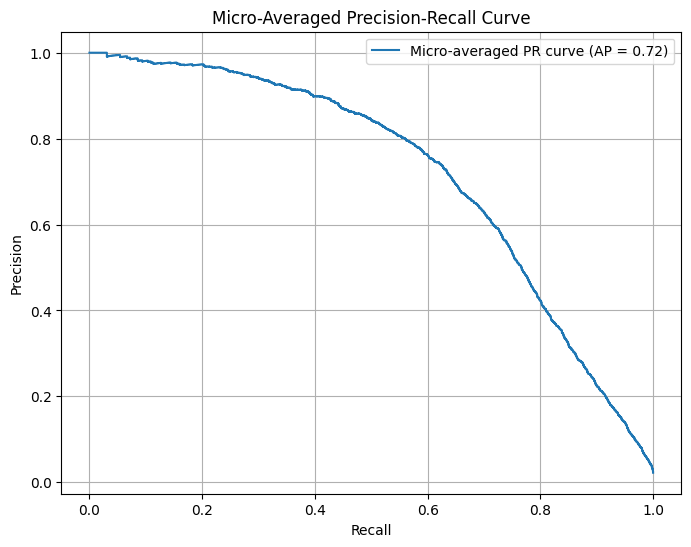

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

class_names = all_ingredients
num_classes = len(class_names)
y_true = val_y  # Shape: (num_samples, num_classes)

y_scores = model.predict(val_x) 
y_pred_binary = (y_scores >= threshold).astype(int)
y_true_binary = y_true.ravel()
y_scores_binary = y_scores.ravel()

# Compute precision and recall for micro-average
precision, recall, _ = precision_recall_curve(y_true_binary, y_scores_binary)
average_precision = average_precision_score(y_true_binary, y_scores_binary, average='micro')

# Plot the micro-averaged Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'Micro-averaged PR curve (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Plot aggregate confusion matrix.

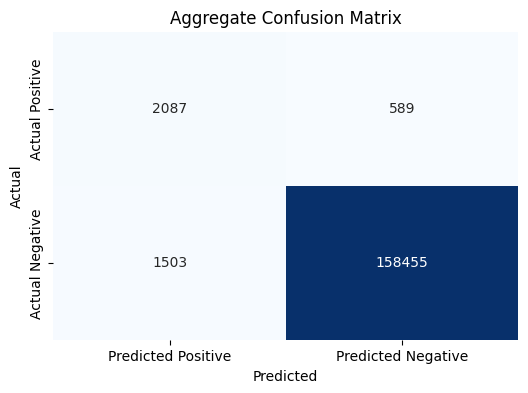

In [21]:
# Sum confusion matrices across all classes
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_binary)
aggregate_cm = confusion_matrices.sum(axis=0)

# Rearrange the confusion matrix
tn, fp, fn, tp = aggregate_cm.ravel()
aggregate_cm_array = np.array([[tp, fp],
                               [fn, tn]])

# Plot the aggregate confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(aggregate_cm_array, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])

plt.title('Aggregate Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute subset accuracy (exact match)
subset_accuracy = accuracy_score(y_true, y_pred_binary)

# Compute metrics with different averaging methods

# Micro-average (globally considers all true positives, false positives, and false negatives)
precision_micro = precision_score(y_true, y_pred_binary, average='micro', zero_division=0)
recall_micro = recall_score(y_true, y_pred_binary, average='micro', zero_division=0)
f1_micro = f1_score(y_true, y_pred_binary, average='micro', zero_division=0)

# Macro-average (unweighted mean of the per-class metrics)
precision_macro = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

# Samples-average (average over each instance)
precision_samples = precision_score(y_true, y_pred_binary, average='samples', zero_division=0)
recall_samples = recall_score(y_true, y_pred_binary, average='samples', zero_division=0)
f1_samples = f1_score(y_true, y_pred_binary, average='samples', zero_division=0)

# Display the results
print("Subset Accuracy (Exact Match): {:.4f}".format(subset_accuracy))

print("\nMicro-Averaged Metrics:")
print("Precision: {:.4f}".format(precision_micro))
print("Recall: {:.4f}".format(recall_micro))
print("F1 Score: {:.4f}".format(f1_micro))

print("\nMacro-Averaged Metrics:")
print("Precision: {:.4f}".format(precision_macro))
print("Recall: {:.4f}".format(recall_macro))
print("F1 Score: {:.4f}".format(f1_macro))

print("\nSamples-Averaged Metrics:")
print("Precision: {:.4f}".format(precision_samples))
print("Recall: {:.4f}".format(recall_samples))
print("F1 Score: {:.4f}".format(f1_samples))

Subset Accuracy (Exact Match): 0.3023

Micro-Averaged Metrics:
Precision: 0.7799
Recall: 0.5813
F1 Score: 0.6661

Macro-Averaged Metrics:
Precision: 0.4691
Recall: 0.2950
F1 Score: 0.3425

Samples-Averaged Metrics:
Precision: 0.7108
Recall: 0.6119
F1 Score: 0.6385


### Plot confusion matrix – raw and normalized.
<p>There are 233 classes, far too many to list them all on the X- and Y- axes. </p>

Number of classes: 233


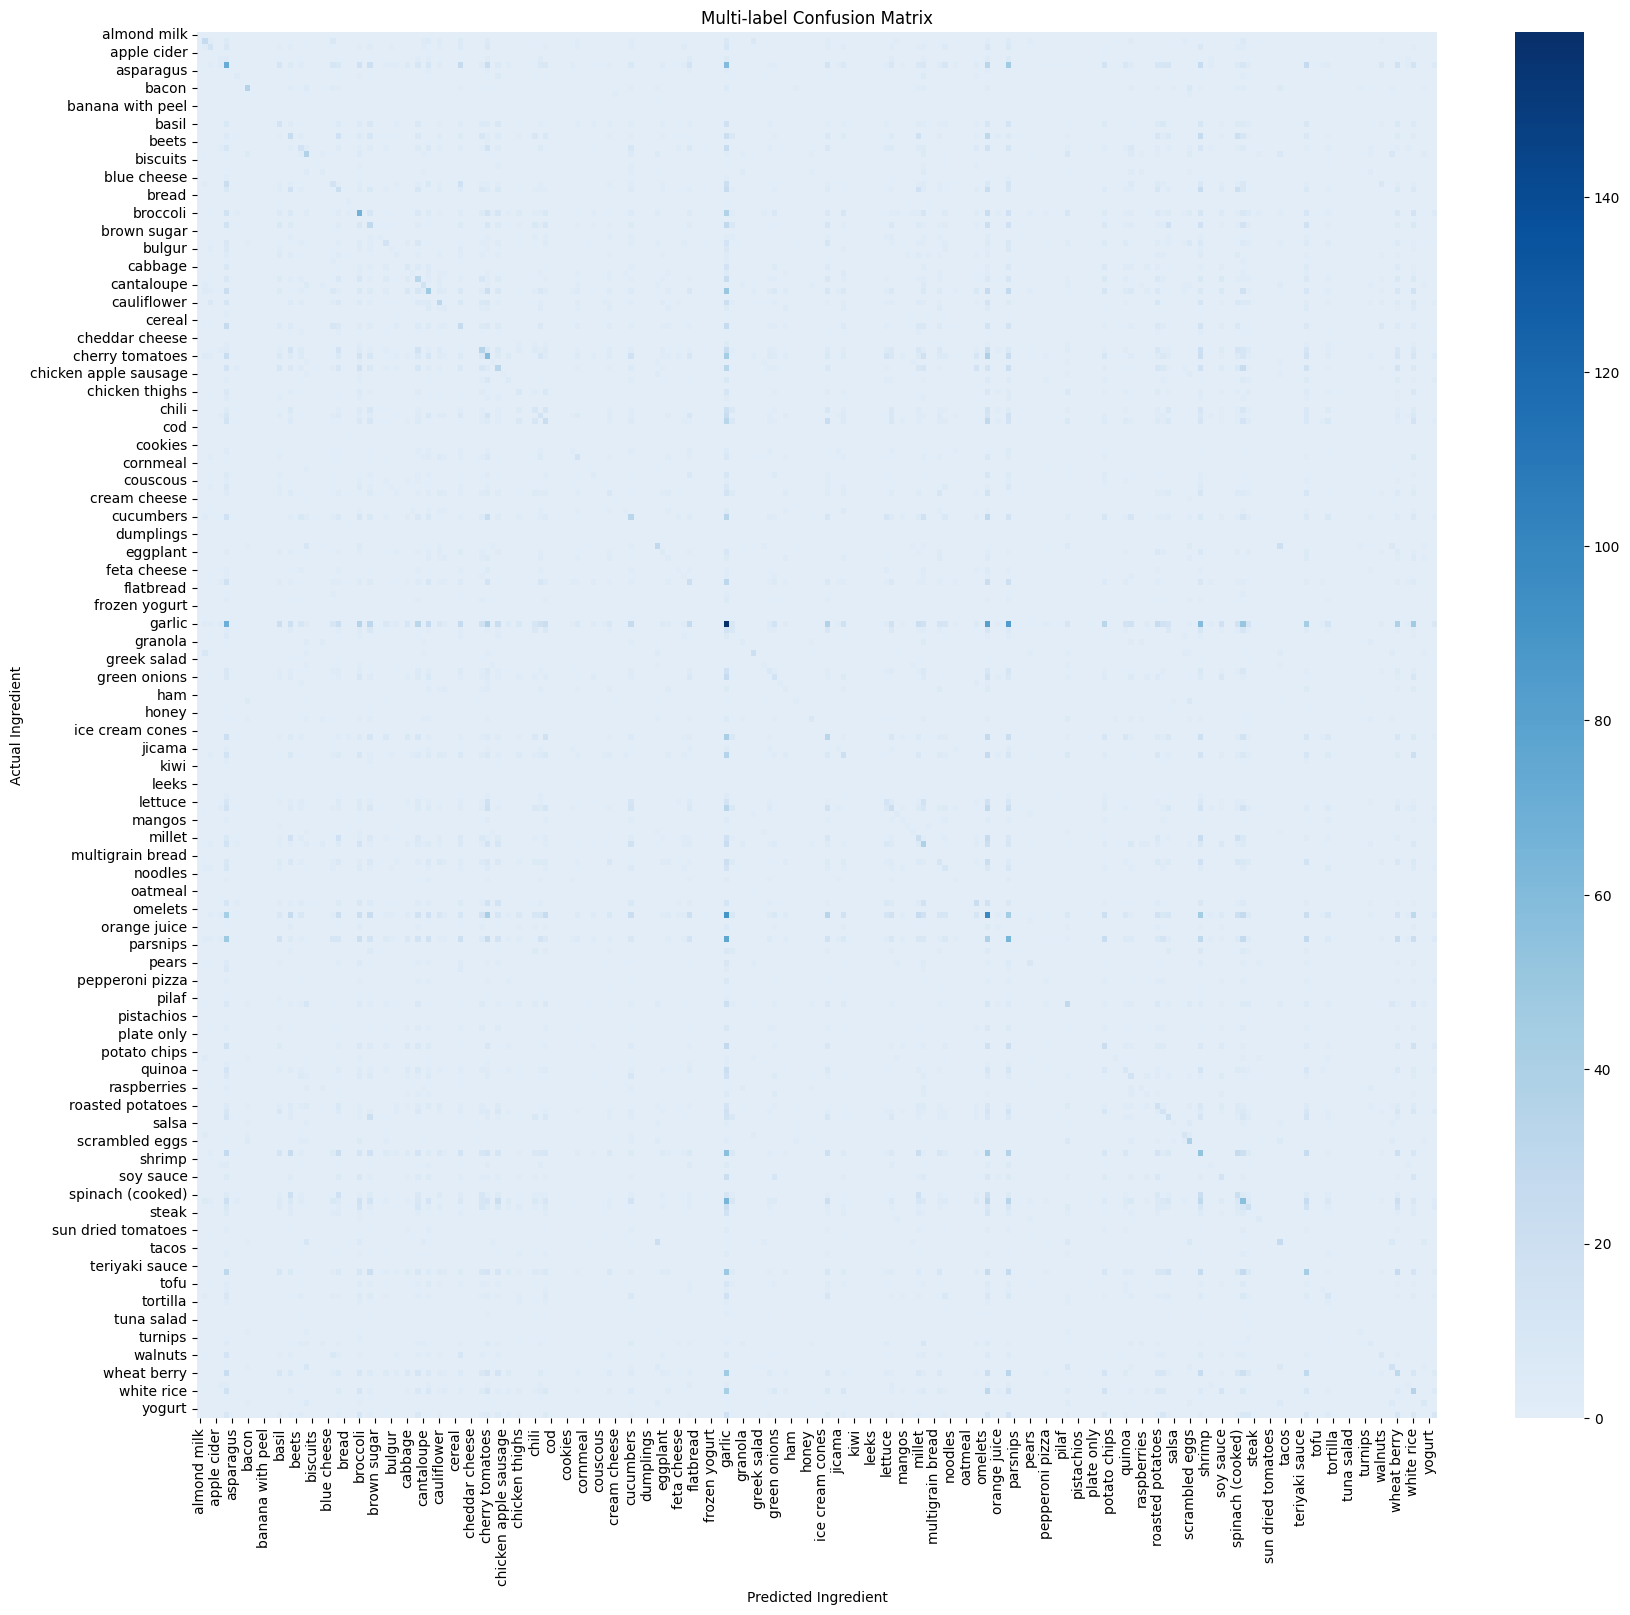

In [23]:
# - y_true: Ground truth binary labels (num_samples, num_classes)
# - y_scores: Predicted probabilities from the model (num_samples, num_classes)
# - all_ingredients: List of all ingredient names (class names)

# Define class_names
class_names = all_ingredients  # Should have length equal to num_classes
num_classes = len(class_names)
print(f'Number of classes: {num_classes}')

# Predictions will be based on the threshold setting
y_pred_binary = (y_scores >= threshold).astype(int)

# Initialize the confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Compute the confusion matrix
for i in range(len(y_true)):
    true_labels = np.where(y_true[i] == 1)[0]         # Indices of true classes
    pred_labels = np.where(y_pred_binary[i] == 1)[0]  # Indices of predicted classes
    
    for t in true_labels:
        for p in pred_labels:
            confusion_matrix[t, p] += 1

# Create the DataFrame
confusion_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

# Plot the Confusion Matrix
plt.figure(figsize=(20, 18))  # Adjust figure size as needed

sns.heatmap(confusion_df, annot=False, fmt='d', cmap='Blues', center=70)

plt.xlabel('Predicted Ingredient')
plt.ylabel('Actual Ingredient')
plt.title('Multi-label Confusion Matrix')
plt.show()

### Plot a normalized confusion matrix, where the sum of each row or column is 1. The diagonal line representing a correct prediction is more apparent.
<p>There are 233 classes, which is too many for the X-axis and Y-axis to contain. Only certain items are displayed.</p>

Number of classes: 233


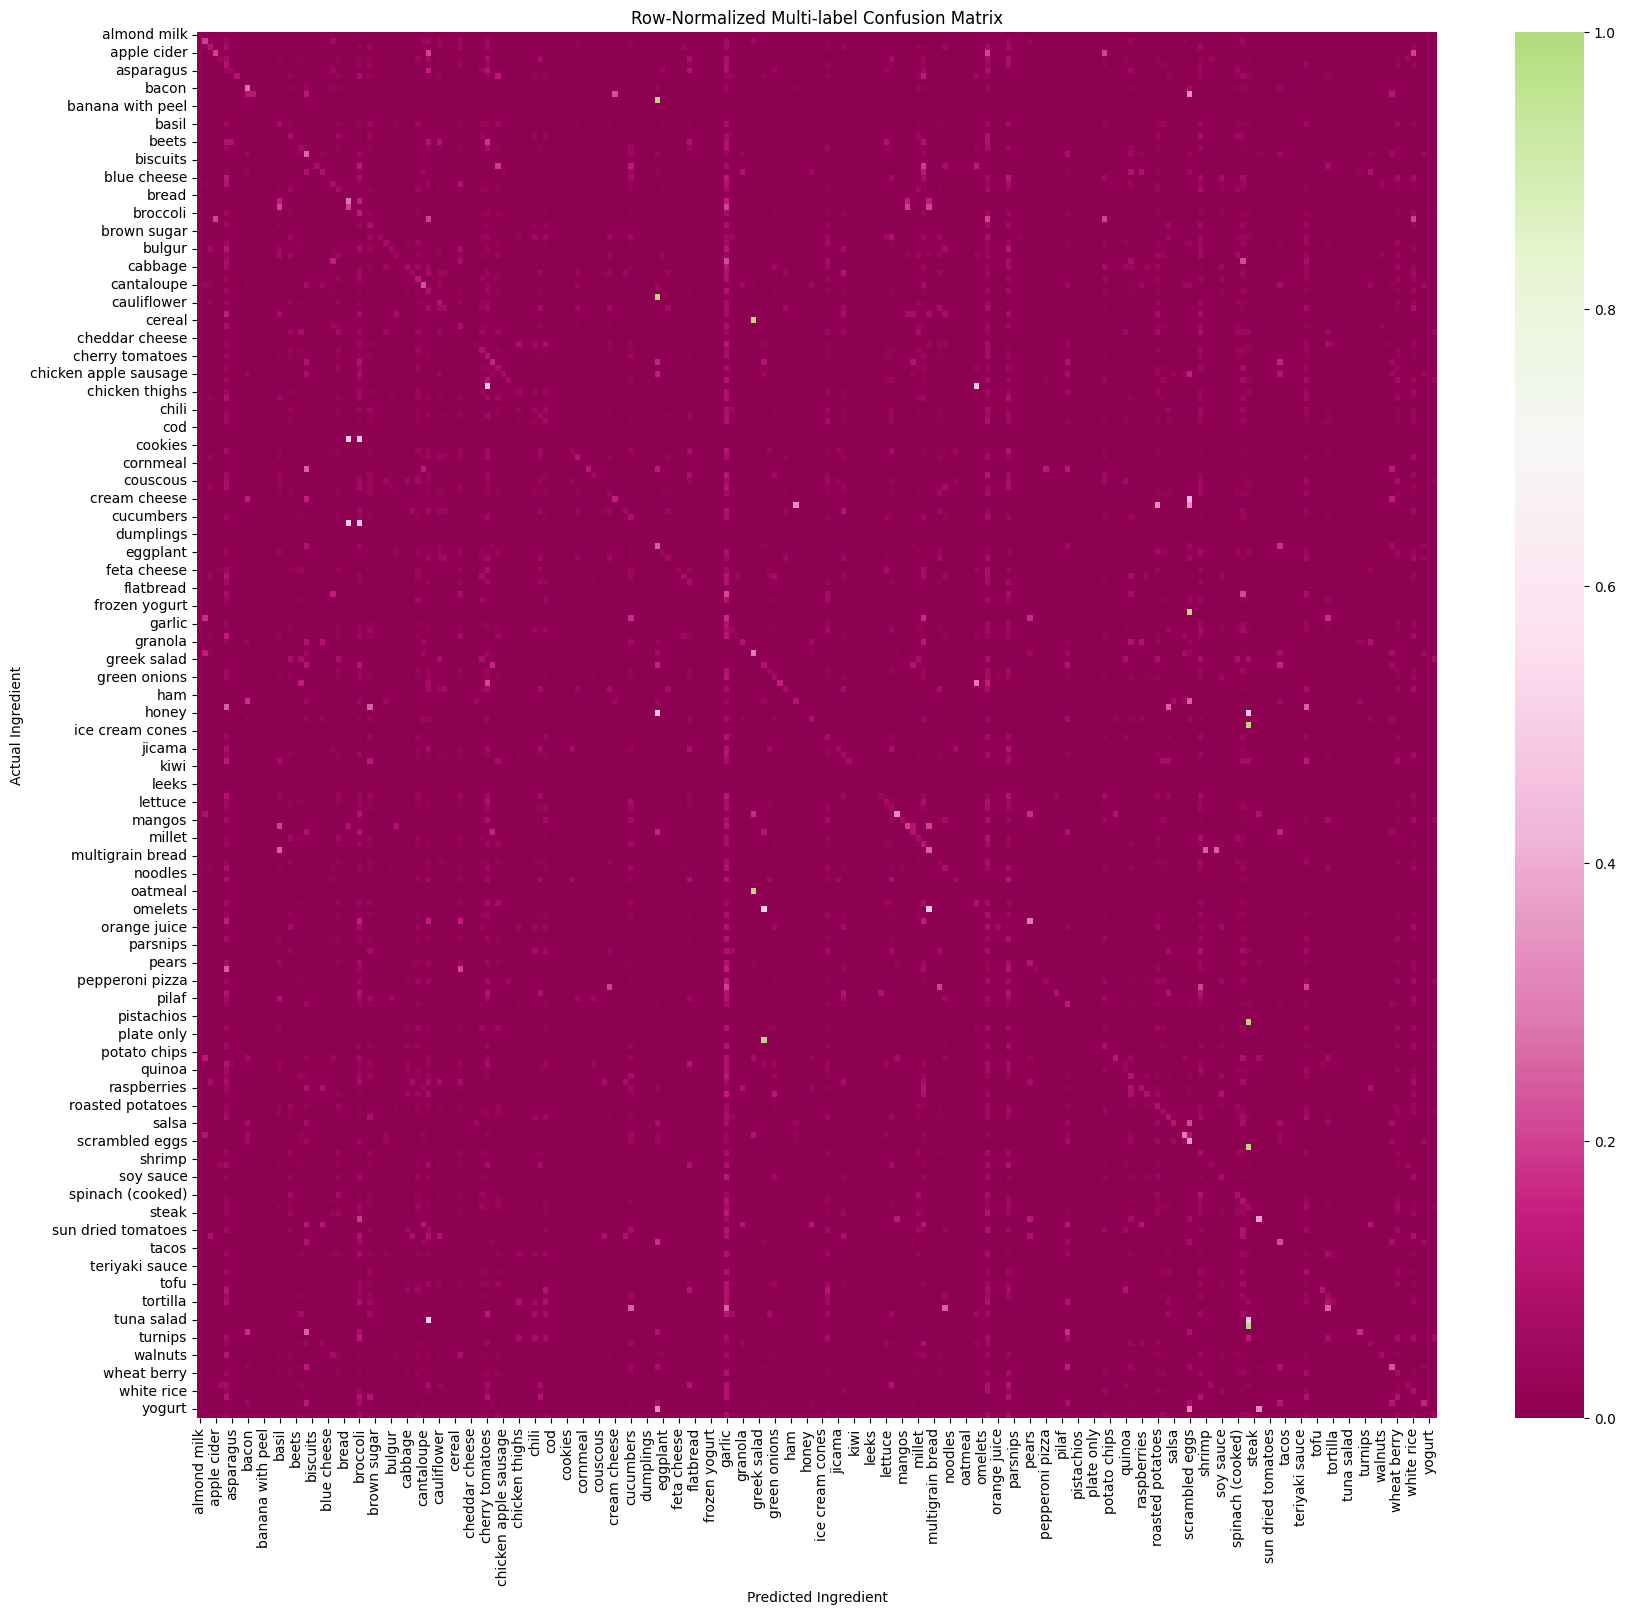

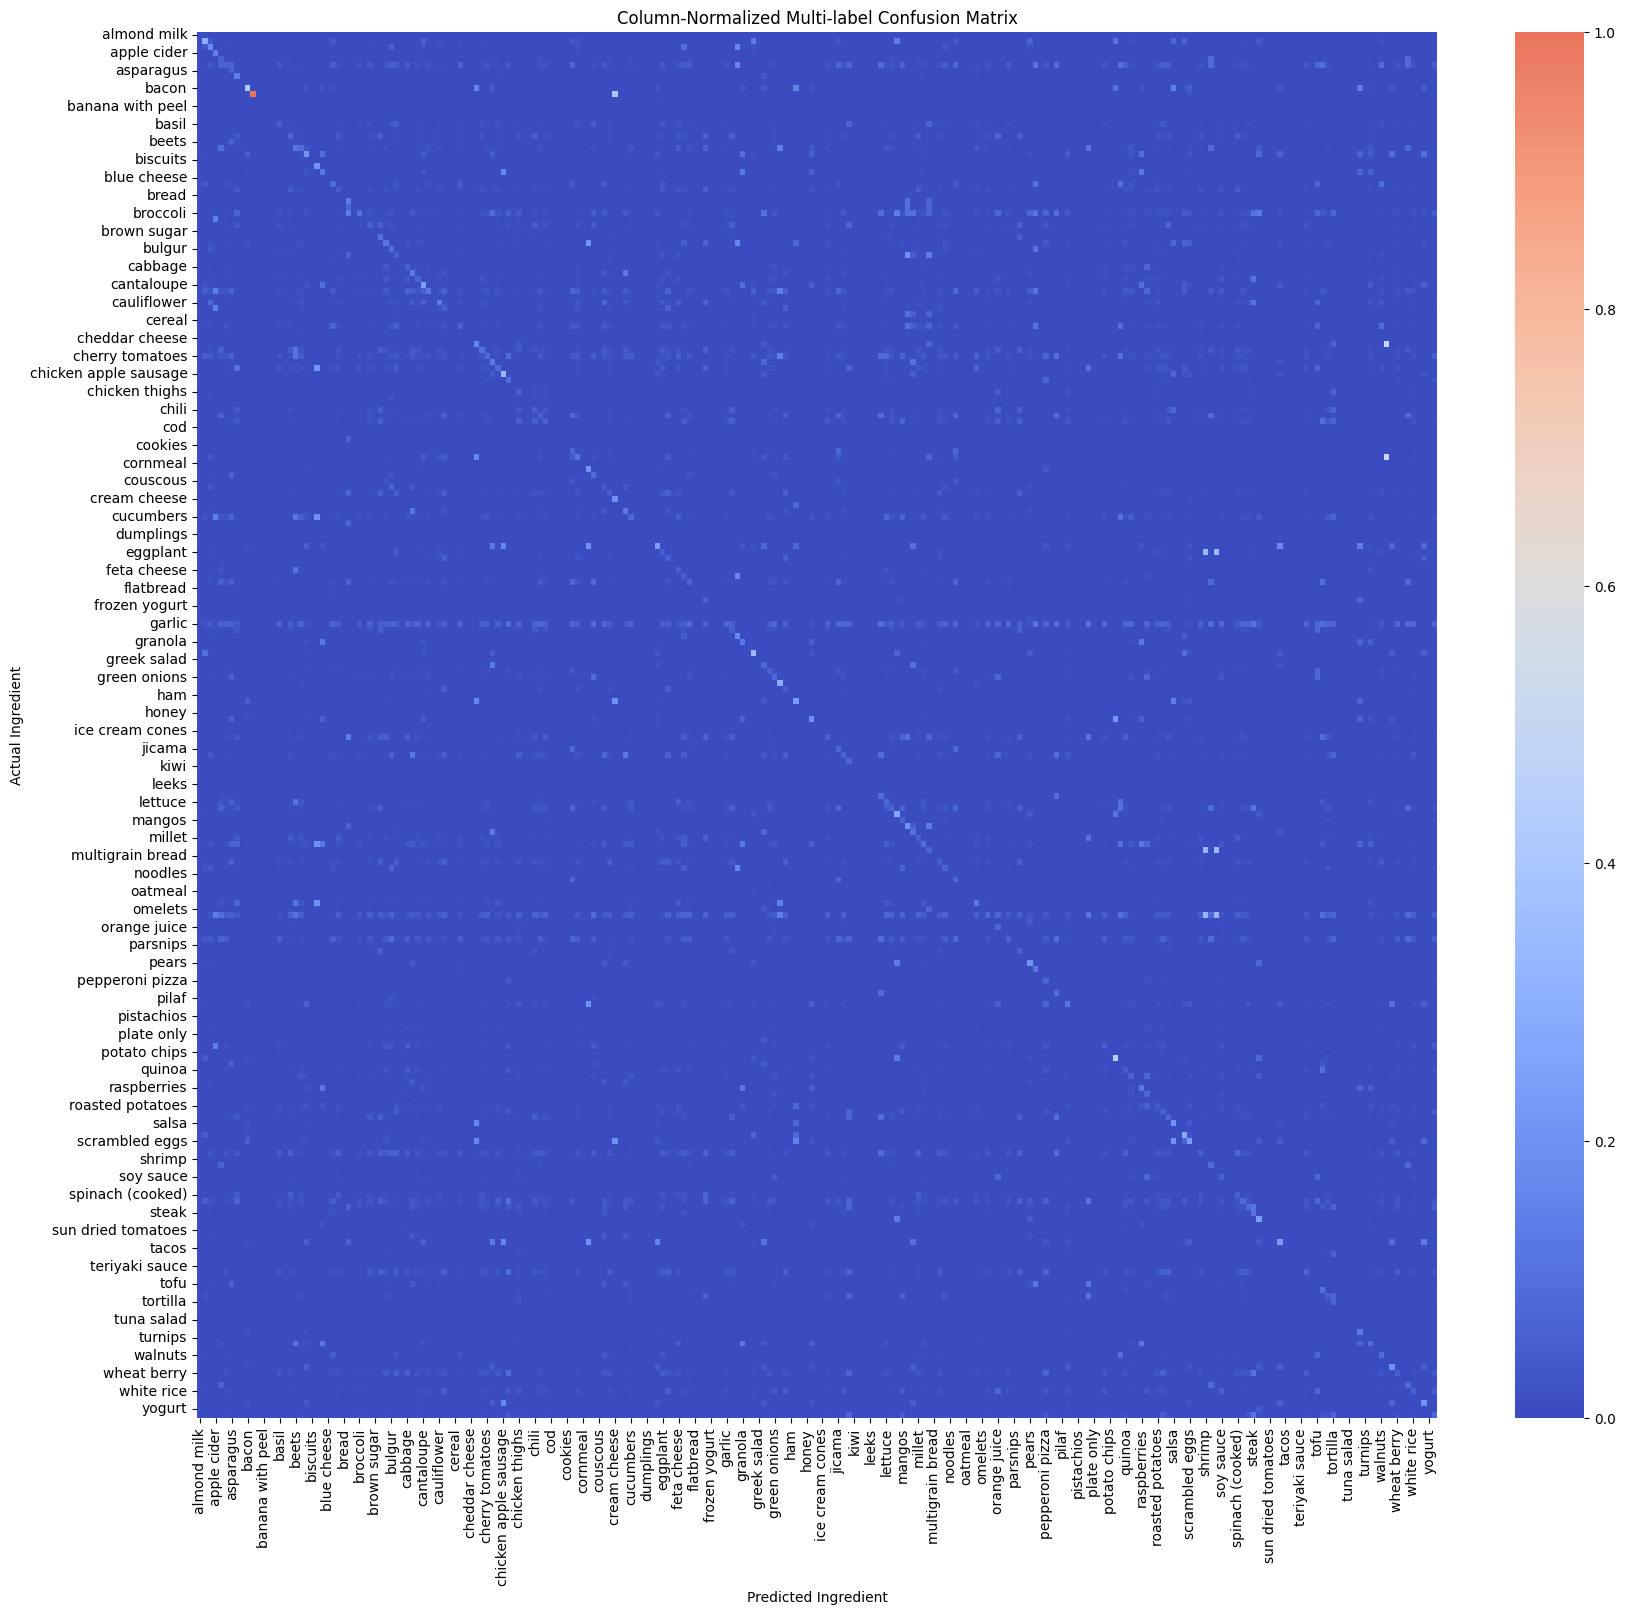

In [24]:
# - y_true: Ground truth binary labels (num_samples, num_classes)
# - y_scores: Predicted probabilities from the model (num_samples, num_classes)
# - all_ingredients: List of all ingredient names (class names)

# Define class_names
class_names = all_ingredients  # Should have length equal to num_classes
num_classes = len(class_names)
print(f'Number of classes: {num_classes}')

# Predictions will be based on the threshold setting
y_pred_binary = (y_scores >= threshold).astype(int)

# Initialize the confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Compute the confusion matrix
for i in range(len(y_true)):
    true_labels = np.where(y_true[i] == 1)[0]         # Indices of true classes
    pred_labels = np.where(y_pred_binary[i] == 1)[0]  # Indices of predicted classes

    for t in true_labels:
        for p in pred_labels:
            confusion_matrix[t, p] += 1

# Create the DataFrame
confusion_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

# Normalize the confusion matrix over rows (true classes)
# Each row sums to 1.0
confusion_df_row_norm = confusion_df.div(confusion_df.sum(axis=1), axis=0).fillna(0)

# Normalize the confusion matrix over columns (predicted classes)
# Each column sums to 1.0
confusion_df_col_norm = confusion_df.div(confusion_df.sum(axis=0), axis=1).fillna(0)

# Normalize the confusion matrix globally (sum of all elements is 1.0)
confusion_df_global_norm = confusion_df / confusion_df.values.sum()

# Plotting all the normalized confusion matrices

# Example: Plot the confusion matrix normalized over rows
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_df_row_norm, cmap='PiYG', center=0.7)
plt.xlabel('Predicted Ingredient')
plt.ylabel('Actual Ingredient')
plt.title('Row-Normalized Multi-label Confusion Matrix')
plt.show()

# Example: Plot the confusion matrix normalized over columns
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_df_col_norm, cmap='coolwarm', center=0.6)
plt.xlabel('Predicted Ingredient')
plt.ylabel('Actual Ingredient')
plt.title('Column-Normalized Multi-label Confusion Matrix')
plt.show()